In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd

!pip install catboost
from catboost import CatBoostRegressor

data_dir = Path("/content/drive/MyDrive/Colab Notebooks/industry_task1/")

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
train = pd.read_csv(data_dir / "train_data.csv", usecols=["timestamp", "lon", "lat"])
valid = pd.read_csv(data_dir / "valid.csv", usecols=["hour", "lat", "lon", "sum", "error"])
test = pd.read_csv(data_dir / "test.csv", usecols=["hour", "lat", "lon", "sum", "error"])

In [ ]:
def preprocess(df, stats=None, filter_extremes=True):
  if filter_extremes:
    # filtering extremes
    extremes = (29.40635082565253 > df.lon) | (df.lon > 32.047397760963925) | (59.656929822910136 > df.lat) | (df.lat > 60.374089897957774)
    print(f"Found {sum(extremes)} extreme values, which make up {sum(extremes) / len(df) * 100}% of data")
    df = df[~extremes]

  to_meters = 111.139
  r = 6371  # km
  for col in ("lat", "lon"):
    df[f"{col}_meters"] = (df[col] * 2 * np.pi * r / 360) * to_meters

  if stats is None:
    lat_min, lon_min = df["lat_meters"].min(), df["lon_meters"].min()
  else:
    lat_min, lon_min = stats
  
  df["date"] = pd.to_datetime(df[("timestamp" if "timestamp" in df.columns else "hour")], unit="s")

  for col in ("lat_meters", "lon_meters"):
    df[f"{col}_discrete"] = ((df[col] - (lat_min if "lat" in col else lon_min)) // 250).astype(np.int32)

  return df, (lat_min, lon_min)

In [ ]:
def create_datetime_features(col):
  col = pd.to_datetime(col, unit="s")
  features = {"day_of_week": col.dt.dayofweek,
              "day": col.dt.day,
              "year": col.dt.year,
              "month": col.dt.month}
  return pd.DataFrame(features)

In [ ]:
train, stats = preprocess(train)
valid, _ = preprocess(valid, stats)
test, _ = preprocess(test, stats)

Found 75894 extreme values, which make up 0.8900928701794845% of data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

Found 23 extreme values, which make up 3.244005641748942% of data
Found 0 extreme values, which make up 0.0% of data


In [ ]:
train = pd.concat((train, create_datetime_features(train["timestamp"])), axis=1)
valid = pd.concat((valid, create_datetime_features(valid["hour"])), axis=1)
test = pd.concat((test, create_datetime_features(test["hour"])), axis=1)

In [ ]:
train = train.groupby(["lat_meters_discrete",	"lon_meters_discrete",	"day", "month", "year", "day_of_week"], as_index=False).agg(count=("timestamp", "count"))

In [ ]:
valid = valid[["sum", "error", "lat_meters_discrete",	"lon_meters_discrete",	"day", "month", "year", "day_of_week"]]
test = test[["sum", "error", "lat_meters_discrete",	"lon_meters_discrete",	"day", "month", "year", "day_of_week"]]

In [ ]:
model = CatBoostRegressor(random_state=42, iterations=10_000)
model.fit(train.drop(columns=["count"]), train["count"])
preds = model.predict(valid.drop(columns=["sum", "error"]))

Выходные данные были обрезаны до нескольких последних строк (5000).
5000:	learn: 73.4970463	total: 57.6s	remaining: 57.6s
5001:	learn: 73.4961334	total: 57.6s	remaining: 57.6s
5002:	learn: 73.4951157	total: 57.6s	remaining: 57.5s
5003:	learn: 73.4941456	total: 57.6s	remaining: 57.5s
5004:	learn: 73.4911321	total: 57.6s	remaining: 57.5s
5005:	learn: 73.4898514	total: 57.6s	remaining: 57.5s
5006:	learn: 73.4868437	total: 57.6s	remaining: 57.5s
5007:	learn: 73.4854841	total: 57.7s	remaining: 57.5s
5008:	learn: 73.4837181	total: 57.7s	remaining: 57.5s
5009:	learn: 73.4823901	total: 57.7s	remaining: 57.4s
5010:	learn: 73.4816351	total: 57.7s	remaining: 57.4s
5011:	learn: 73.4791475	total: 57.7s	remaining: 57.4s
5012:	learn: 73.4778711	total: 57.7s	remaining: 57.4s
5013:	learn: 73.4775512	total: 57.7s	remaining: 57.4s
5014:	learn: 73.4754935	total: 57.7s	remaining: 57.4s
5015:	learn: 73.4742567	total: 57.7s	remaining: 57.4s
5016:	learn: 73.4738153	total: 57.7s	remaining: 57.3s
5017:	learn: 7

In [ ]:
metric = lambda prediction, ground_truth: np.mean(np.abs(prediction - ground_truth) / prediction)

metric(preds, valid["sum"])

0.9709948880840378

In [ ]:
test_preds = model.predict(test.drop(columns=["sum", "error"]))

metric(test_preds, test["sum"])

0.971829833513419

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

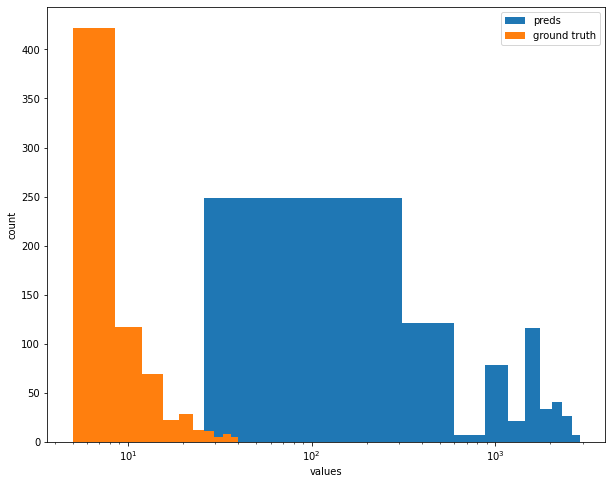

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(test_preds, label="preds")
ax.hist(test["sum"], label="ground truth")
ax.set_xscale("log")
ax.set_xlabel("values")
ax.set_ylabel("count")
ax.legend(loc='upper right')
plt.show()

# Without filtering extremes

In [ ]:
train = pd.read_csv(data_dir / "train_data.csv", usecols=["timestamp", "lon", "lat"])
valid = pd.read_csv(data_dir / "valid.csv", usecols=["hour", "lat", "lon", "sum", "error"])
test = pd.read_csv(data_dir / "test.csv", usecols=["hour", "lat", "lon", "sum", "error"])

train, stats = preprocess(train, filter_extremes=False)
valid, _ = preprocess(valid, stats, filter_extremes=False)
test, _ = preprocess(test, stats, filter_extremes=False)

train = pd.concat((train, create_datetime_features(train["timestamp"])), axis=1)
valid = pd.concat((valid, create_datetime_features(valid["hour"])), axis=1)
test = pd.concat((test, create_datetime_features(test["hour"])), axis=1)

train = train.groupby(["lat_meters_discrete",	"lon_meters_discrete",	"day", "month", "year", "day_of_week"], as_index=False).agg(count=("timestamp", "count"))
valid = valid[["sum", "error", "lat_meters_discrete",	"lon_meters_discrete",	"day", "month", "year", "day_of_week"]]
test = test[["sum", "error", "lat_meters_discrete",	"lon_meters_discrete",	"day", "month", "year", "day_of_week"]]

model = CatBoostRegressor(random_state=42, iterations=10_000, silent=True)
model.fit(train.drop(columns=["count"]), train["count"])
preds = model.predict(valid.drop(columns=["sum", "error"]))
test_preds = model.predict(test.drop(columns=["sum", "error"]))

print("valid", metric(preds, valid["sum"]))
print("test", metric(test_preds, test["sum"]))

valid 0.965762776352657
test 0.9693265485982222
